In [1]:
import importlib
import CTProjector.src.ct_projector.recon.cupy 

# do some work with my_module...

# if you make changes to the code in my_module, you can reload the module like this:
importlib.reload(CTProjector.src.ct_projector.recon.cupy)

<module 'CTProjector.src.ct_projector.recon.cupy' from '/workspace/Documents/CTProjector/src/ct_projector/recon/cupy/__init__.py'>

In [2]:
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt
import nibabel as nb


import HeadCT_motion_correction_PAR.motion_simulator.motion_simulation.ct_basic as basic
import HeadCT_motion_correction_PAR.functions_collection as ff
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform

import CTProjector.src.ct_projector.projector.cupy as ct_projector
import CTProjector.src.ct_projector.projector.cupy.fan_equiangular as ct_fan
import CTProjector.src.ct_projector.projector.numpy.fan_equiangluar as numpy_fan

import CTProjector.src.ct_projector.prior.cupy as ct_prior
import CTProjector.src.ct_projector.recon.cupy as ct_recon



## Prepare image and sinogram

In [3]:
# load a sample CT image
filename = '/mnt/mount_zc_NAS/motion_correction/data/raw_data/nii-images/thin_slice/MO101701M000006/MO001A000007/img-nii-2.5/img.nii.gz'
img,spacing,affine = basic.basic_image_processing(filename)
print(img.shape, spacing)

save_folder = '/mnt/mount_zc_NAS/motion_correction/data/test_sinograms/'

# img_ds = ff.crop_or_pad(img,[71,230,230])
img_ds = np.copy(img)
img_ds = img_ds[np.newaxis, ...]
print(img_ds.shape)
truth = img_ds[0,...]/ 0.019 * 1000 - 1024


# plt.figure(figsize = (8,4))
# plt.subplot(121); plt.imshow(ff.set_window(truth[15,...].T,500, 2000), 'gray')
# plt.subplot(122); plt.imshow(ff.set_window(truth[50, :, :].T,50, 100), 'gray')

(71, 234, 234) [2.5266578 1.        1.       ]
(1, 71, 234, 234)


In [4]:
def generate_and_save_sinograms_spline_motion(img, total_angle, amplitude_tx, amplitude_ty, amplitude_tz, amplitude_rx, amplitude_ry, amplitude_rz, file_name , sga = 0, load_file = False, geometry = 'fan', total_view_num = 1000, increment = 100):
    t = np.linspace(0, 500, 5, endpoint=True)
    print(t)
    spline_tx = transform.interp_func(t, np.asarray(amplitude_tx))
    spline_ty = transform.interp_func(t, np.asarray(amplitude_ty))
    spline_tz = transform.interp_func(t, np.asarray(amplitude_tz))
    spline_rx = transform.interp_func(t, np.asarray(amplitude_rx))
    spline_ry = transform.interp_func(t, np.asarray(amplitude_ry))
    spline_rz = transform.interp_func(t, np.asarray(amplitude_rz))

    print(geometry)
    projector = basic.define_forward_projector(img,spacing,total_view_num)
    angles = ff.get_angles_zc(total_view_num, total_angle, sga)

    if load_file == False:
        sinogram = basic.fp_w_spline_motion_model(img, projector, angles,3,  spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, total_view = total_view_num, gantry_rotation_time = 500, slice_num = None, increment = increment, order = 3)

        np.save(file_name, sinogram)
    else:
        sinogram = np.load(file_name, allow_pickle = True)

    return angles, sinogram, total_angle, spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, projector


file_name = os.path.join(save_folder,'spline1.npy')
geometry = 'fan'
sga = 0
angles, sinogram, total_angle, spline_tx, spline_ty, spline_tz, spline_rx, spline_ry, spline_rz, geometry, projector = generate_and_save_sinograms_spline_motion(img_ds, 360, np.linspace(0,10,5), np.linspace(0,10,5), np.linspace(0,0,5), np.linspace(0,0/180*np.pi,5), np.linspace(0,0/180*np.pi,5), np.linspace(0,10/180*np.pi,5), file_name , sga = sga, load_file = True, geometry = geometry)

[  0. 125. 250. 375. 500.]
fan


## Make FBP

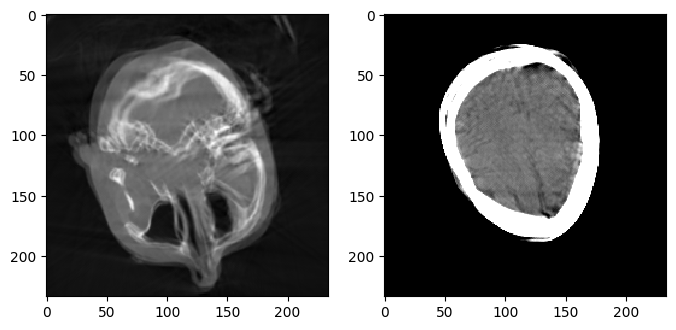

In [5]:
# directly make backprojection
fbp_projector = basic.backprojector(img_ds,spacing)
fbp_motion = basic.filtered_backporjection(sinogram,angles,projector,fbp_projector, geometry, back_to_original_value = True)

truth = img_ds[0,...]/ 0.019 * 1000 - 1024

plt.figure(figsize = (8,4))
plt.subplot(121); plt.imshow(ff.set_window(fbp_motion[15,...].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(fbp_motion[50, :, :].T,50, 100), 'gray')
nb.save(nb.Nifti1Image(np.rollaxis(fbp_motion,0,3),affine), '/mnt/mount_zc_NAS/motion_correction/data/test_sinograms/motion.nii.gz')

In [6]:
total_views = 1000
gantry_time = 500
# define how many PARs you want to make:
K = 10
# define use whole or half sinogram?
use = 'whole'

if use[0] == 'w':
    sinogram2 = np.copy(sinogram)
    angles2 = np.copy(angles)
    time2 = gantry_time
    
else:
    sinogram2 = sinogram[:, 0: sinogram.shape[1]//2, :, :]
    angles2 = angles[0: sinogram.shape[1]//2]
    time2 = gantry_time/2

# define the time window for each PAR
times = np.linspace(time2/K, time2, K)
    
projector2 = basic.define_forward_projector(img_ds,spacing,sinogram.shape[1])
fbp_projector2 = basic.backprojector(img_ds,spacing)

# divide sinogram:
sinogram_segments,  num_angles_in_one_segment, segment_indexes = basic.divide_sinogram_direct_num(sinogram2, K , sinogram2.shape[1])

##### IMPORTANT  - assign weights to sinogram projection data according to in-plane rotation:
sinogram_weighted, weights = transform.weighted_projection_due_to_rotation(sinogram_segments, segment_indexes, spline_rz, total_views, K,times, angles, sga, use_affine_transform = True)

# make PAR:
final_par = basic.make_PAR_new(sinogram_weighted, segment_indexes,  angles2, img_ds[0,...].shape, projector2, fbp_projector2, geometry = geometry, back_to_original_value=False)

# apply ground truth motion:
PAR_transformed_true_sinogram = np.copy(final_par)
for j in range(0,PAR_transformed_true_sinogram.shape[0]):
    t_end =[times[j]]
    translation_ = [-spline_tz(t_end) , -spline_tx(t_end), -spline_ty(t_end)]
    rotation_ = [-spline_rz(t_end), -spline_rx(t_end), -spline_ry(t_end)] 
    print(j, translation_, [rr/np.pi*180 for rr in rotation_])
    I = final_par[j,...]
    _,_,_,transformation_matrix = transform.generate_transform_matrix(translation_,rotation_,[1,1,1],I.shape, which_one_is_first = 'translation') # need to inverse the action
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_new = transform.apply_affine_transform(I, transformation_matrix, order = 3, cval = np.min(I))

    PAR_transformed_true_sinogram[j,...] = img_new

PAR = np.sum(PAR_transformed_true_sinogram,axis=0) / (K) * 2
PAR = PAR / 0.019 * 1000 - 1024
plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(ff.set_window(PAR[15,:,:].T,500, 2000), 'gray')
plt.subplot(122); plt.imshow(ff.set_window(PAR[15,:,:].T,50, 100), 'gray')

0 [array([-0.]), array([-1.]), array([-1.])] [array([-1.]), array([-0.]), array([-0.])]


/workspace/Documents/HeadCT_motion_correction_PAR/motion_simulator/transformation/rotation_matrix_from_angle.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(
/workspace/Documents/HeadCT_motion_correction_PAR/motion_simulator/transformation/rotation_matrix_from_angle.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(
/workspace/Documents/HeadCT_motion_correction_PAR/motion_simulator/transformation/rotation_matrix_from_angle.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which i

1 [array([-0.]), array([-2.]), array([-2.])] [array([-2.]), array([-0.]), array([-0.])]
2 [array([-0.]), array([-3.]), array([-3.])] [array([-3.]), array([-0.]), array([-0.])]
3 [array([-0.]), array([-4.]), array([-4.])] [array([-4.]), array([-0.]), array([-0.])]
4 [array([-0.]), array([-5.]), array([-5.])] [array([-5.]), array([-0.]), array([-0.])]


KeyboardInterrupt: 

In [16]:
nb.save(nb.Nifti1Image(np.rollaxis(PAR,0,3),affine), os.path.join('/mnt/mount_zc_NAS/motion_correction/data/','test_sinograms/PAR_corrected.nii.gz'))

## Iterative recon

In [6]:
def back_to_HU(recon):
    return recon / 0.019 * 1000 - 1024
img_ds2 = np.copy(img_ds[:, 30:35,:,:])

In [7]:
projector_ir = projector

angles = ff.get_angles_zc(1000, 360,0)

origin_img = img_ds2[0,...]
origin_img = origin_img[:,np.newaxis,...]
print(origin_img.shape)

(5, 1, 234, 234)


projection shape:  (5, 1000, 1, 736)
fbp shape:  (5, 1, 234, 234)


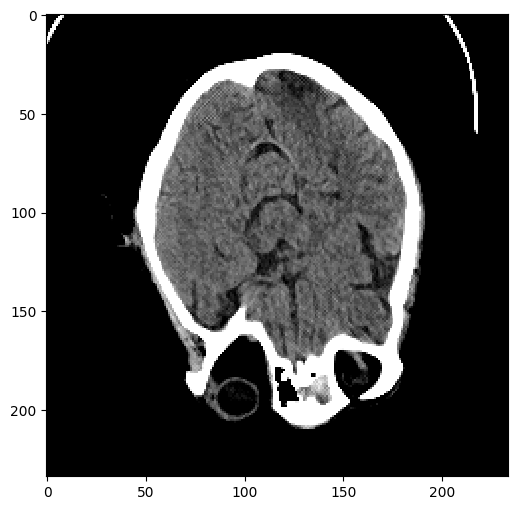

In [8]:
curef = cp.array(origin_img, order='C')
cuangles = cp.array(angles, order='C')

projector_ir.set_projector(ct_fan.distance_driven_fp, angles=cuangles, branchless = False)
projector_ir.set_backprojector(ct_fan.distance_driven_bp, angles=cuangles, is_fbp = True)

cuprj = projector_ir.fp(curef, angles=cuangles)
prj = cuprj.get()
print('projection shape: ',prj.shape)

fprj = numpy_fan.ramp_filter(projector_ir, prj, filter_type = 'rl')
cufprj = cp.array(fprj, cp.float32, order = 'C')
fbp = projector_ir.bp(cufprj)
fbp = fbp.get()

print('fbp shape: ',fbp.shape)
plt.figure(figsize=[6,6])
plt.imshow(back_to_HU(fbp[0, 0].T), 'gray',vmin=0, vmax=100)

In [9]:
print(img_ds2.shape)
img_ds3 = np.squeeze(img_ds2)[:,np.newaxis,:,:]
print(img_ds3.shape)

(1, 5, 234, 234)
(5, 1, 234, 234)


In [10]:
PAR = nb.load('/mnt/mount_zc_NAS/motion_correction/data/test_sinograms/PAR_corrected.nii.gz').get_fdata()
PAR = np.rollaxis(PAR,2,0)
PAR_corrected = (PAR.astype(np.float32) + 1024) / 1000 * 0.019
PAR_corrected = PAR_corrected[30:35,np.newaxis,...]

fbp_motion2 = (fbp_motion.astype(np.float32) + 1024) / 1000 * 0.019
fbp_motion2 = fbp_motion2[30:35,np.newaxis,...]

sinogram_part = sinogram[30:35,...]


# TV reconstruction
niter = 1
nos = 1  ######## what's os and nos?
nesterov = 0.5
beta = 0.001
zero_init = False

projector_norm = projector_ir.calc_projector_norm()
cunorm_img = projector_ir.calc_norm_img() / projector_norm / projector_norm

cufbp = cp.array(img_ds3 ,order='C')
cuprj2 = cp.array(sinogram_part, cp.float32, order = 'C')
cuangles = cp.array(angles, order='C')


if zero_init:
    curecon = cp.zeros(cufbp.shape, cp.float32)
    cunesterov = cp.zeros(cufbp.shape, cp.float32)
else:    
    curecon = cp.copy(cufbp)
    cunesterov = cp.copy(curecon)

for i in range(0,niter):
    for os in range(0,nos):

        curecon, cunesterov = ct_recon.nesterov_acceleration_motion(
            ct_recon.sqs_gaussian_one_step_motion,
            img=curecon,
            img_nesterov=cunesterov,
            recon_kwargs={
                'projector': projector_ir,
                'prj': cuprj2,
                'norm_img': cunorm_img,
                'projector_norm': projector_norm,
                'beta': beta
            }
        )

    # if (i + 1) % 10 == 0:
    _, data_loss, prior_loss = ct_recon.sqs_gaussian_one_step_motion(
        projector_ir,
        curecon,
        cuprj2,
        cunorm_img,
        projector_norm,
        beta,
        return_loss=True
    )

    print(i + 1, data_loss, prior_loss)

0,1,2,3,4,5,6,7,8,9,


/workspace/Documents/HeadCT_motion_correction_PAR/motion_simulator/transformation/rotation_matrix_from_angle.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(
/workspace/Documents/HeadCT_motion_correction_PAR/motion_simulator/transformation/rotation_matrix_from_angle.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(
/workspace/Documents/HeadCT_motion_correction_PAR/motion_simulator/transformation/rotation_matrix_from_angle.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which i

1 0.0 1.5413098


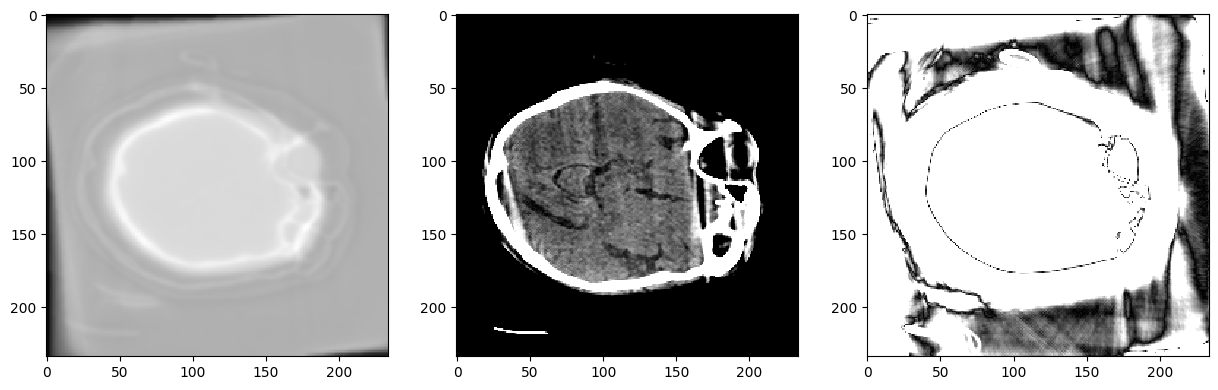

In [16]:
recon_ir = curecon.get()[:,0,:,:]
recon_ir = recon_ir / 0.019 * 1000 - 1024
plt.figure(figsize = (15,5))
plt.subplot(131); plt.imshow(recon_ir[1,...], 'gray')   
plt.subplot(132); plt.imshow(back_to_HU(PAR_corrected[1, 0]), 'gray', vmin=0, vmax=100) 
plt.subplot(133); plt.imshow(np.abs(back_to_HU(PAR_corrected[1, 0]) - recon_ir[1,...]), 'gray', vmin=0, vmax=100)                 

In [10]:
nb.save(nb.Nifti1Image(np.rollaxis(recon_ir,0,3),affine), '/mnt/mount_zc_NAS/motion_correction/data/test_sinograms/IR_corrected.nii.gz')

NameError: name 'affine' is not defined

In [24]:
import numpy as np

# Define the transformation matrix T
T = np.array([[1, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

# Create a 3D grid of points representing each voxel in the image
grid = np.indices((5, 5, 4))
grid = np.vstack((grid, np.ones((1, grid.shape[1], grid.shape[2], grid.shape[3]))))

# Apply the transformation matrix to the grid of points
transformed_grid = T @ grid.reshape(4, -1)

# Calculate the motion vectors by subtracting the original grid from the transformed grid
motion_vectors = transformed_grid[:3, :].reshape(3, 5, 5, 4) - grid[:3, :]

print(motion_vectors.shape)

print(motion_vectors[:,0,3,1])

(3, 5, 5, 4)
[1. 0. 0.]
